# From experiments 1, 2 and 3

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torchvision.models import inception_v3, Inception_V3_Weights

import os
import glob
from PIL import Image
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_w = 1920
image_h = 1080
dummy_img = torch.zeros(1, 3, image_h, image_w).float()

In [3]:
class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d,
            model.Mixed_6a,
            model.Mixed_6b,
            model.Mixed_6c,
            model.Mixed_6d,
            model.Mixed_6e,
            model.Mixed_7a, 
            model.Mixed_7b, 
            model.Mixed_7c
        )
        
    def forward(self, x):
        return self.feature_extractor(x)
    
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval() 
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 2048, 32, 58])
Number of channels: 2048
Spatial dimensions: 32x58


# Experiment 4

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- (from Exp2) anchor‐generation routines ---

def generate_base_anchors(scales, aspect_ratios, down_h, down_w):
    ctr_y, ctr_x = down_h/2.0, down_w/2.0
    A = len(scales) * len(aspect_ratios)
    base = np.zeros((A,4), dtype=np.float32)
    idx = 0
    for s in scales:
        for ar in aspect_ratios:
            h = down_h * s * np.sqrt(ar)
            w = down_w * s * np.sqrt(1/ar)
            base[idx,0] = ctr_y - h/2.0  # y_min
            base[idx,1] = ctr_x - w/2.0  # x_min
            base[idx,2] = ctr_y + h/2.0  # y_max
            base[idx,3] = ctr_x + w/2.0  # x_max
            idx += 1
    return base

def generate_anchor_boxes(fmap_size, base_anchors, down_h, down_w):
    Hf, Wf = fmap_size
    shift_y = np.arange(0, Hf) * down_h
    shift_x = np.arange(0, Wf) * down_w
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.stack([shift_y.ravel(), shift_x.ravel(),
                       shift_y.ravel(), shift_x.ravel()], axis=1)
    K = shifts.shape[0]; A = base_anchors.shape[0]
    all_ = base_anchors.reshape((1,A,4)) + shifts.reshape((K,1,4))
    return all_.reshape((K*A,4))

def compute_iou(boxes1, boxes2):
    # boxes: [ymin, xmin, ymax, xmax]
    N, M = boxes1.shape[0], boxes2.shape[0]
    y1 = np.maximum(boxes1[:,None,0], boxes2[None,:,0])
    x1 = np.maximum(boxes1[:,None,1], boxes2[None,:,1])
    y2 = np.minimum(boxes1[:,None,2], boxes2[None,:,2])
    x2 = np.minimum(boxes1[:,None,3], boxes2[None,:,3])
    h = np.clip(y2 - y1, 0, None)
    w = np.clip(x2 - x1, 0, None)
    inter = h * w
    area1 = (boxes1[:,2]-boxes1[:,0])*(boxes1[:,3]-boxes1[:,1])
    area2 = (boxes2[:,2]-boxes2[:,0])*(boxes2[:,3]-boxes2[:,1])
    union = area1[:,None] + area2[None,:] - inter
    return inter / union






Frame 000001: 938 positives, 449302 negatives found
Frame 000001 positive anchor scales: [2, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3, 3, 2.5, 3, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 5, 5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3, 3.5, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 5, 5, 3, 3.5, 3.5, 4, 4, 5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 5, 5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 4, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 4, 4, 4, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 4, 4, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 4, 4, 3.5, 3.5, 3.5, 4, 4, 4, 3, 3.5, 3.5, 

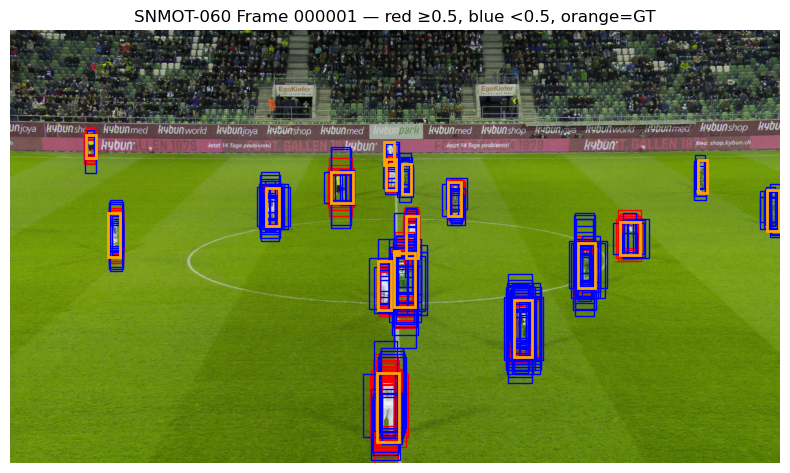

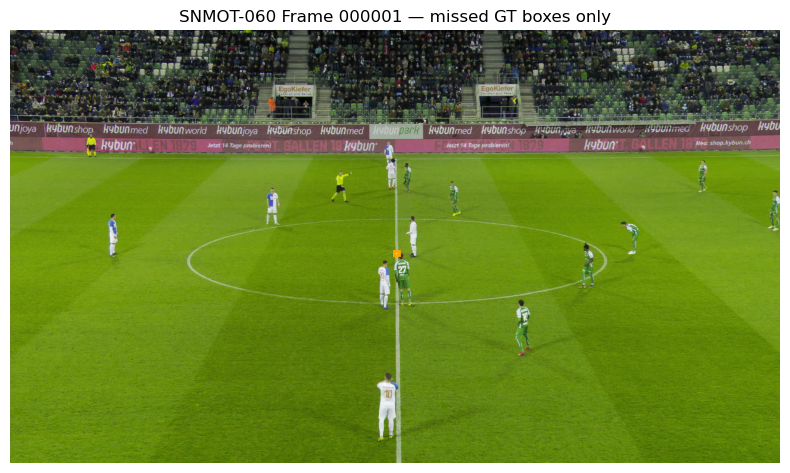

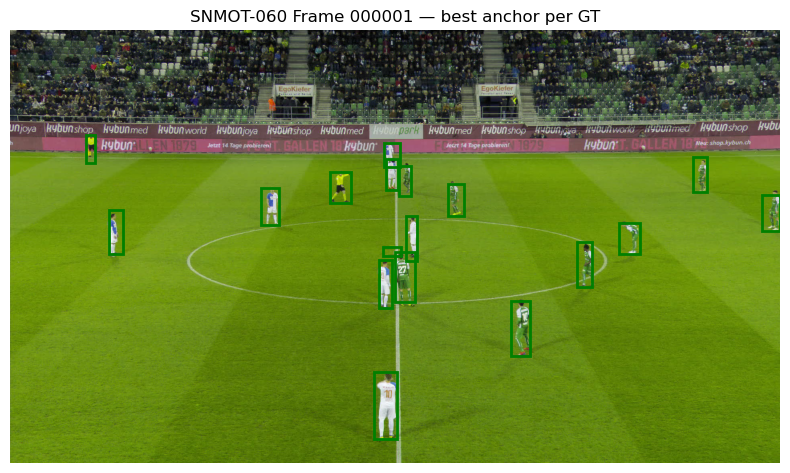

Frame 000002: 966 positives, 449274 negatives found
Frame 000002 positive anchor scales: [2, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3, 3, 2.5, 3, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 5, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 4, 5, 3.5, 3.5, 3.5, 4, 4, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 

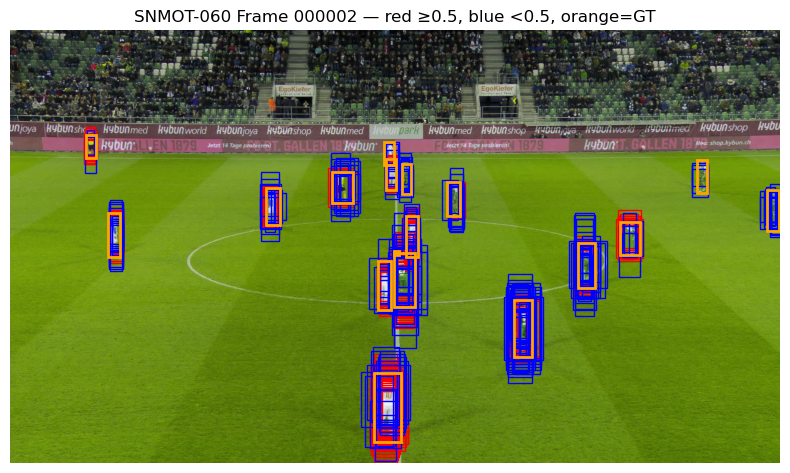

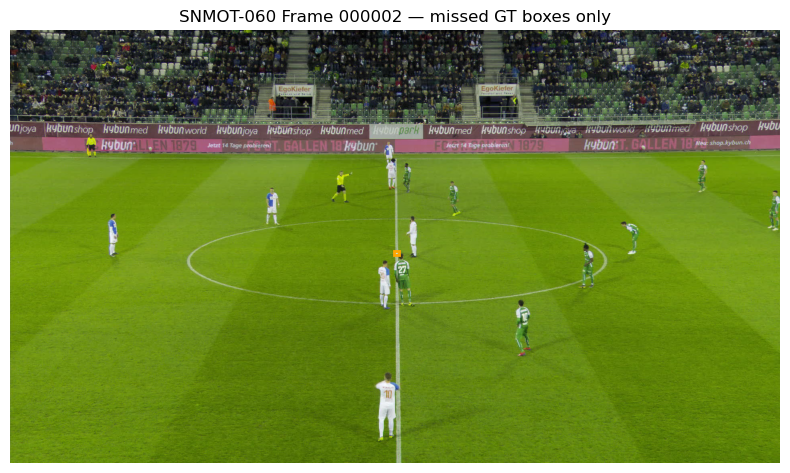

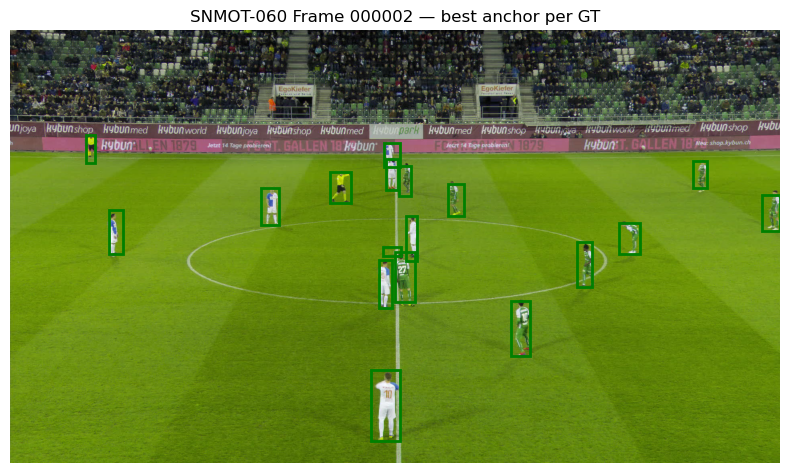

Frame 000003: 960 positives, 449280 negatives found
Frame 000003 positive anchor scales: [2, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3, 3, 2.5, 3, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 2, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 5, 5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 2, 2, 2, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3, 3, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 3, 3, 3, 3, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 5, 5, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 3.5, 3.5, 4, 4, 4, 3, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4, 4, 4, 4, 4, 4, 5, 5, 3, 3, 3, 3.5, 3.5, 3.5

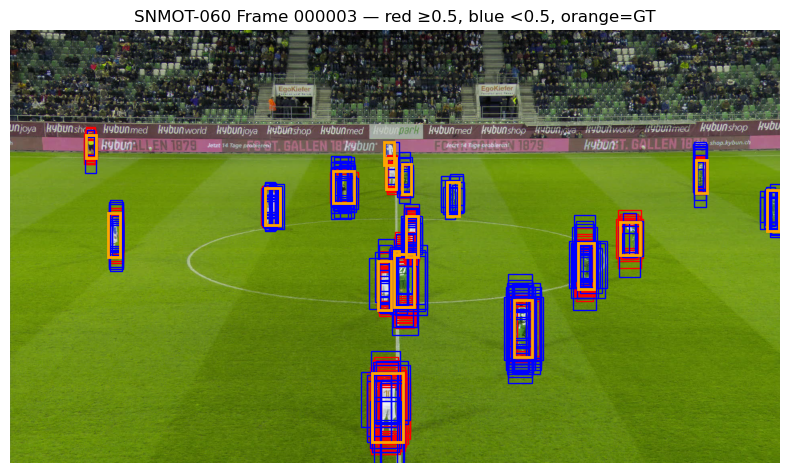

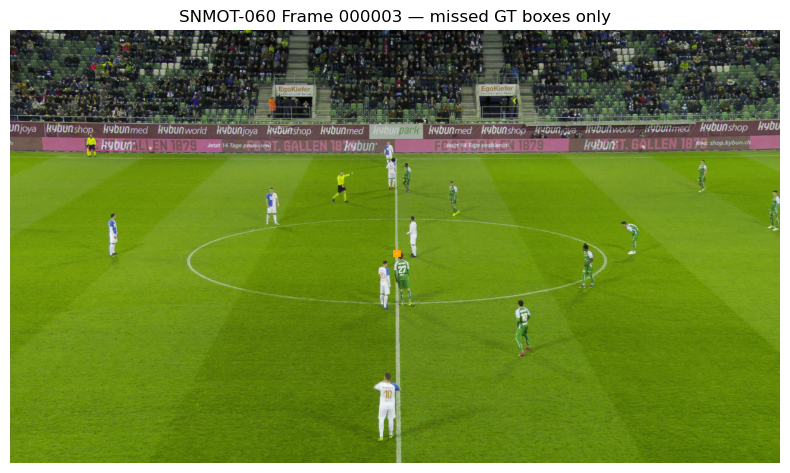

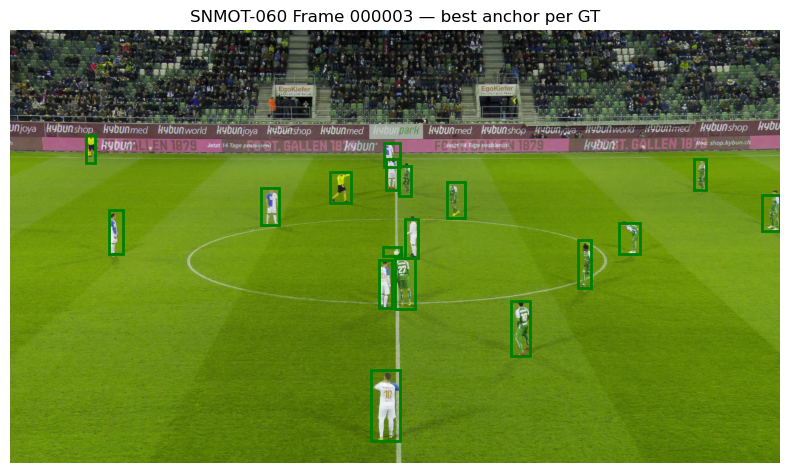

In [12]:
# --- parameters ---
sequence_id   = "SNMOT-060"
frame_ids     = [1,2,3]
pos_thresh    = 0.5
neg_thresh    = 0.5
# scales        = [2, 4, 8]
scales        = [2, 2.5, 3, 3.5, 4, 5,6, 7]
aspect_ratios = [0.5, 1.5, 2.0, 2.5, 3, 3.5, 4]

down_h = down_w = 16           # assume backbone stride=16
max_display   = 200           

for fid in frame_ids:
    # load image
    img_path = os.path.join("..","soccernet_data","tracking","train",
                             sequence_id,"img1",f"{fid:06d}.jpg")
    img = np.array(Image.open(img_path))
    H, W = img.shape[:2]

    # make anchors over this image
    fmap_h, fmap_w = H//down_h, W//down_w
    base_anchors = generate_base_anchors(scales, aspect_ratios, down_h, down_w)
    all_anchors  = generate_anchor_boxes((fmap_h, fmap_w),
                                         base_anchors, down_h, down_w)

    # load per-frame GT
    gt_path = os.path.join("..","soccernet_data","tracking","train",
                            sequence_id,"gt-frame",f"{fid:06d}.txt")
    raw = np.loadtxt(gt_path, delimiter=",")
    raw = raw.reshape(-1,5)      # in case only one box
    gt_boxes = raw[:,1:]         # drop track_id, now [ymin, xmin, ymax, xmax]

    # compute IoU and select +ve / -ve
    ious    = compute_iou(all_anchors, gt_boxes)
    max_iou = ious.max(axis=1)
    pos_idx = np.where(max_iou >= pos_thresh)[0]
    neg_idx = np.where(max_iou <  neg_thresh)[0]

    # debug info
    print(f"Frame {fid:06d}: {len(pos_idx)} positives, {len(neg_idx)} negatives found")

    # print scales and aspect ratios for positive anchors
    A = len(scales) * len(aspect_ratios)
    base_indices      = pos_idx % A
    scale_indices     = base_indices // len(aspect_ratios)
    ar_indices        = base_indices % len(aspect_ratios)
    pos_scales        = [scales[i] for i in scale_indices]
    pos_aspect_ratios = [aspect_ratios[j] for j in ar_indices]
    print(f"Frame {fid:06d} positive anchor scales: {pos_scales}")
    print(f"Frame {fid:06d} positive anchor aspect ratios: {pos_aspect_ratios}")

    # compute and print actual scales & aspect ratios for GT boxes with no positive hit
    num_gt   = gt_boxes.shape[0]
    missed_gt = [j for j in range(num_gt) if ious[:, j].max() < pos_thresh]
    if missed_gt:
        actual_scales = []
        actual_ars    = []
        for j in missed_gt:
            y1, x1, y2, x2 = gt_boxes[j]
            h = y2 - y1
            w = x2 - x1
            ar = h / w
            s  = np.sqrt((h * w) / (down_h * down_w))
            actual_scales.append(round(s, 3))
            actual_ars.append(round(ar, 3))
        print(f"Frame {fid:06d} missed GT indices: {missed_gt}")
        print(f"Frame {fid:06d} missed GT actual scales: {actual_scales}")
        print(f"Frame {fid:06d} missed GT actual aspect ratios: {actual_ars}")
        # also print the highest IoU for each missed GT box
        max_ious = [round(float(ious[:, j].max()), 3) for j in missed_gt]
        print(f"Frame {fid:06d} missed GT max IoUs: {max_ious}")
        
    else:
        print(f"Frame {fid:06d} all GT boxes had at least one positive anchor")

    # # sample up to max_display for clarity
    # if len(pos_idx) > max_display:
    #     pos_idx = np.random.choice(pos_idx, max_display, replace=False)
    # if len(neg_idx) > max_display:
    #     neg_idx = np.random.choice(neg_idx, max_display, replace=False)

    # sample up to max_display for clarity
    if len(pos_idx) > max_display:
        # take the top‑max_display positives by descending IoU
        pos_ious = max_iou[pos_idx]
        order   = np.argsort(-pos_ious)
        pos_idx = pos_idx[order][:max_display]

    if len(neg_idx) > max_display:
        # take the top‑max_display “hard” negatives (i.e. those with highest IoU below the neg_thresh)
        neg_ious = max_iou[neg_idx]
        order   = np.argsort(-neg_ious)
        neg_idx = neg_idx[order][:max_display]

    # plot
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)

    # positives in red
    for i in pos_idx:
        y1,x1,y2,x2 = all_anchors[i]
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # negatives in blue
    for i in neg_idx:
        y1,x1,y2,x2 = all_anchors[i]
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)

    # ground-truth in orange
    for (y1, x1, y2, x2) in gt_boxes:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"{sequence_id} Frame {fid:06d} — red ≥{pos_thresh}, blue <{neg_thresh}, orange=GT")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

     # --- Plot: only the missed GT boxes ---
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    for j in missed_gt:
        y1, x1, y2, x2 = gt_boxes[j]
        rect = patches.Rectangle((x1, y1),
                                 x2-x1, y2-y1,
                                 linewidth=2,
                                 edgecolor='orange',
                                 facecolor='none')
        ax.add_patch(rect)
    ax.set_title(f"{sequence_id} Frame {fid:06d} — missed GT boxes only")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Plot: best anchor per GT ---
    best_anchor_per_gt = np.argmax(ious, axis=0)  # one anchor index per GT
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    for anc_idx in best_anchor_per_gt:
        y1, x1, y2, x2 = all_anchors[anc_idx]
        rect = patches.Rectangle((x1, y1),
                                 x2-x1, y2-y1,
                                 linewidth=2,
                                 edgecolor='g',
                                 facecolor='none')
        ax.add_patch(rect)
    ax.set_title(f"{sequence_id} Frame {fid:06d} — best anchor per GT")
    ax.axis('off')
    plt.tight_layout()
    plt.show()
